# Deep Q-Network implementation.

This homework shamelessly demands you to implement a DQN - an approximate q-learning algorithm with experience replay and target networks - and see if it works any better this way.

Original paper:
https://arxiv.org/pdf/1312.5602.pdf

**This notebook is given for debug.** The main task is in the other notebook (**homework_pytorch_main**). The tasks are similar and share most of the code. The main difference is in environments. In main notebook it can take some 2 hours for the agent to start improving so it seems reasonable to launch the algorithm on a simpler env first. Here it is CartPole and it will train in several minutes.

**We suggest the following pipeline:** First implement debug notebook then implement the main one.

**About evaluation:** All points are given for the main notebook with one exception: if agent fails to beat the threshold in main notebook you can get 1 pt (instead of 3 pts) for beating the threshold in debug notebook.

In [25]:
# # in google colab uncomment this

# import os

# os.system('apt-get install -y xvfb')
# os.system('wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/fall18/xvfb -O ../xvfb')
# os.system('apt-get install -y python-opengl ffmpeg')
# os.system('pip install pyglet==1.2.4')

# os.system('python -m pip install -U pygame --user')

# prefix = 'https://raw.githubusercontent.com/yandexdataschool/Practical_RL/spring19/week04_approx_rl/'

# os.system('wget ' + prefix + 'atari_wrappers.py')
# os.system('wget ' + prefix + 'utils.py')
# os.system('wget ' + prefix + 'replay_buffer.py')
# os.system('wget ' + prefix + 'framebuffer.py')

# print('setup complete')

# XVFB will be launched if you run on a server
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    %env DISPLAY = : 1

__Frameworks__ - we'll accept this homework in any deep learning framework. This particular notebook was designed for pytoch, but you find it easy to adapt it to almost any python-based deep learning framework.

In [26]:
import random
import numpy as np
import torch
import utils

In [27]:
import gym
import numpy as np
import matplotlib.pyplot as plt

### CartPole again

In [28]:
ENV_NAME = 'CartPole-v1'

def make_env(seed=None):
    # CartPole is wrapped with a time limit wrapper by default
    env = gym.make(ENV_NAME).unwrapped
    if seed is not None:
        env.seed(seed)
    return env

In [29]:
env = make_env()
env.reset()
state_shape, n_actions = env.observation_space.shape, env.action_space.n


### Building a network

We now need to build a neural network that can map observations to state q-values.
The model does not have to be huge yet. 1-2 hidden layers with < 200 neurons and ReLU activation will probably be enough. Batch normalization and dropout can spoil everything here.

In [30]:
import torch
import torch.nn as nn
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# those who have a GPU but feel unfair to use it can uncomment:
# device = torch.device('cpu')
device

device(type='cpu')

In [31]:
import torch.nn.functional as F

class DQNAgent(nn.Module):
    def __init__(self, state_shape, n_actions, epsilon=0):

        super().__init__()
        self.epsilon = epsilon
        self.n_actions = n_actions
        self.state_shape = state_shape
        # Define your network body here. Please make sure agent is fully contained here
        assert len(state_shape) == 1
        state_dim = state_shape[0]
        #<YOUR CODE>
        self.l1 = nn.Linear(state_dim, 256)
        self.l2 = nn.Linear(256, n_actions)


        
    def forward(self, state_t):
        """
        takes agent's observation (tensor), returns qvalues (tensor)
        :param state_t: a batch states, shape = [batch_size, *state_dim=4]
        """
        # Use your network to compute qvalues for given state
        #qvalues = <YOUR CODE>
        state_t = F.relu(self.l1(state_t))
        qvalues = self.l2(state_t)

        assert qvalues.requires_grad, "qvalues must be a torch tensor with grad"
        assert len(
            qvalues.shape) == 2 and qvalues.shape[0] == state_t.shape[0] and qvalues.shape[1] == n_actions

        return qvalues

    def get_qvalues(self, states):
        """
        like forward, but works on numpy arrays, not tensors
        """
        model_device = next(self.parameters()).device
        states = torch.tensor(states, device=model_device, dtype=torch.float32)
        qvalues = self.forward(states)
        return qvalues.data.cpu().numpy()

    def sample_actions(self, qvalues):
        """pick actions given qvalues. Uses epsilon-greedy exploration strategy. """
        epsilon = self.epsilon
        batch_size, n_actions = qvalues.shape

        random_actions = np.random.choice(n_actions, size=batch_size)
        best_actions = qvalues.argmax(axis=-1)

        should_explore = np.random.choice(
            [0, 1], batch_size, p=[1-epsilon, epsilon])
        return np.where(should_explore, random_actions, best_actions)

In [32]:
agent = DQNAgent(state_shape, n_actions, epsilon=0.3).to(device)

Now let's try out our agent to see if it raises any errors.

In [33]:
def evaluate(env, agent, n_games=1, greedy=False, t_max=10000):
    """ Plays n_games full games. If greedy, picks actions as argmax(qvalues). Returns mean reward. """
    rewards = []
    for _ in range(n_games):
        s = env.reset()
        reward = 0
        for _ in range(t_max):
            qvalues = agent.get_qvalues([s])
            action = qvalues.argmax(axis=-1)[0] if greedy else agent.sample_actions(qvalues)[0]
            s, r, done, _ = env.step(action)
            reward += r
            if done:
                break

        rewards.append(reward)
    return np.mean(rewards)

In [34]:
evaluate(env, agent, n_games=1)

10.0

### Experience replay
For this assignment, we provide you with experience replay buffer. If you implemented experience replay buffer in last week's assignment, you can copy-paste it here in main notebook **to get 2 bonus points**.

![img](https://github.com/yandexdataschool/Practical_RL/raw/master/yet_another_week/_resource/exp_replay.png)

#### The interface is fairly simple:
* `exp_replay.add(obs, act, rw, next_obs, done)` - saves (s,a,r,s',done) tuple into the buffer
* `exp_replay.sample(batch_size)` - returns observations, actions, rewards, next_observations and is_done for `batch_size` random samples.
* `len(exp_replay)` - returns number of elements stored in replay buffer.

In [35]:
from replay_buffer import ReplayBuffer
exp_replay = ReplayBuffer(10)

for _ in range(30):
    exp_replay.add(env.reset(), env.action_space.sample(),
                   1.0, env.reset(), done=False)

obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(
    5)

assert len(exp_replay) == 10, "experience replay size should be 10 because that's what maximum capacity is"

In [36]:
def play_and_record(initial_state, agent, env, exp_replay, n_steps=1):
    """
    Play the game for exactly n steps, record every (s,a,r,s', done) to replay buffer. 
    Whenever game ends, add record with done=True and reset the game.
    It is guaranteed that env has done=False when passed to this function.

    PLEASE DO NOT RESET ENV UNLESS IT IS "DONE"

    :returns: return sum of rewards over time and the state in which the env stays
    """
    s = initial_state
    sum_rewards = 0

    # Play the game for n_steps as per instructions above
    #<YOUR CODE >
    for _ in range(n_steps):
        qvalues = agent.get_qvalues([s])
        action = agent.sample_actions(qvalues)[0]
        new_s, r, done, _ = env.step(action)
        exp_replay.add(s, action, r, new_s, done)
        s = new_s
        if done:
            s = env.reset()
        sum_rewards += r
    

    return sum_rewards, s

In [37]:
# testing your code.
exp_replay = ReplayBuffer(2000)

state = env.reset()
play_and_record(state, agent, env, exp_replay, n_steps=1000)

# if you're using your own experience replay buffer, some of those tests may need correction.
# just make sure you know what your code does
assert len(exp_replay) == 1000, "play_and_record should have added exactly 1000 steps, "\
                                 "but instead added %i" % len(exp_replay)
is_dones = list(zip(*exp_replay._storage))[-1]

assert 0 < np.mean(is_dones) < 0.1, "Please make sure you restart the game whenever it is 'done' and record the is_done correctly into the buffer."\
                                    "Got %f is_done rate over %i steps. [If you think it's your tough luck, just re-run the test]" % (
                                        np.mean(is_dones), len(exp_replay))

for _ in range(100):
    obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(
        10)
    assert obs_batch.shape == next_obs_batch.shape == (10,) + state_shape
    assert act_batch.shape == (
        10,), "actions batch should have shape (10,) but is instead %s" % str(act_batch.shape)
    assert reward_batch.shape == (
        10,), "rewards batch should have shape (10,) but is instead %s" % str(reward_batch.shape)
    assert is_done_batch.shape == (
        10,), "is_done batch should have shape (10,) but is instead %s" % str(is_done_batch.shape)
    assert [int(i) in (0, 1)
            for i in is_dones], "is_done should be strictly True or False"
    assert [
        0 <= a < n_actions for a in act_batch], "actions should be within [0, n_actions]"

print("Well done!")

Well done!


### Target networks

We also employ the so called "target network" - a copy of neural network weights to be used for reference Q-values:

The network itself is an exact copy of agent network, but it's parameters are not trained. Instead, they are moved here from agent's actual network every so often.

$$ Q_{reference}(s,a) = r + \gamma \cdot \max _{a'} Q_{target}(s',a') $$

![img](https://github.com/yandexdataschool/Practical_RL/raw/master/yet_another_week/_resource/target_net.png)

In [38]:
target_network = DQNAgent(agent.state_shape, agent.n_actions, epsilon=0.5).to(device)
# This is how you can load weights from agent into target network
target_network.load_state_dict(agent.state_dict())

### Learning with... Q-learning
Here we write a function similar to `agent.update` from tabular q-learning.

Compute Q-learning TD error:

$$ L = { 1 \over N} \sum_i [ Q_{\theta}(s,a) - Q_{reference}(s,a) ] ^2 $$

With Q-reference defined as

$$ Q_{reference}(s,a) = r(s,a) + \gamma \cdot max_{a'} Q_{target}(s', a') $$

Where
* $Q_{target}(s',a')$ denotes q-value of next state and next action predicted by __target_network__
* $s, a, r, s'$ are current state, action, reward and next state respectively
* $\gamma$ is a discount factor defined two cells above.


__Note 1:__ there's an example input below. Feel free to experiment with it before you write the function.

__Note 2:__ compute_td_loss is a source of 99% of bugs in this homework. If reward doesn't improve, it often helps to go through it line by line [with a rubber duck](https://rubberduckdebugging.com/).

In [39]:
def compute_td_loss(states, actions, rewards, next_states, is_done,
                    agent, target_network,
                    gamma=0.99,
                    check_shapes=False,
                    device=device):
    """ Compute td loss using torch operations only. Use the formulae above. """
    states = torch.tensor(states, device=device, dtype=torch.float)    # shape: [batch_size, *state_shape]

    # for some torch reason should not make actions a tensor
    actions = torch.tensor(actions, device=device, dtype=torch.long)    # shape: [batch_size]
    rewards = torch.tensor(rewards, device=device, dtype=torch.float)  # shape: [batch_size]
    # shape: [batch_size, *state_shape]
    next_states = torch.tensor(next_states, device=device, dtype=torch.float)
    is_done = torch.tensor(
        is_done.astype('float32'),
        device=device,
        dtype=torch.float
    )  # shape: [batch_size]
    is_not_done = 1 - is_done

    # get q-values for all actions in current states
    predicted_qvalues = agent(states)

    # compute q-values for all actions in next states
    predicted_next_qvalues = target_network(next_states)
    
    # select q-values for chosen actions
    predicted_qvalues_for_actions = predicted_qvalues[range(
        len(actions)), actions]

    # compute V*(next_states) using predicted next q-values
    next_state_values, _ = predicted_next_qvalues.max(-1)#<YOUR CODE>
    #print(predicted_next_qvalues,predicted_next_qvalues.max(-1))
    #exit(0)

    assert next_state_values.dim(
    ) == 1 and next_state_values.shape[0] == states.shape[0], "must predict one value per state"

    # compute "target q-values" for loss - it's what's inside square parentheses in the above formula.
    # at the last state use the simplified formula: Q(s,a) = r(s,a) since s' doesn't exist
    # you can multiply next state values by is_not_done to achieve this.
    target_qvalues_for_actions = rewards + gamma * next_state_values * is_not_done
    #target_network.get_qvalues(actions)#YOUR CODE>

    # mean squared error loss to minimize
    loss = torch.mean((predicted_qvalues_for_actions -
                       target_qvalues_for_actions.detach()) ** 2)

    if check_shapes:
        assert predicted_next_qvalues.data.dim(
        ) == 2, "make sure you predicted q-values for all actions in next state"
        assert next_state_values.data.dim(
        ) == 1, "make sure you computed V(s') as maximum over just the actions axis and not all axes"
        assert target_qvalues_for_actions.data.dim(
        ) == 1, "there's something wrong with target q-values, they must be a vector"

    return loss

Sanity checks

In [40]:
obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(
    10)

loss = compute_td_loss(obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch,
                       agent, target_network,
                       gamma=0.99, check_shapes=True)
loss.backward()

assert loss.requires_grad and tuple(loss.data.size()) == (
    ), "you must return scalar loss - mean over batch"
assert np.any(next(agent.parameters()).grad.data.cpu().numpy() !=
              0), "loss must be differentiable w.r.t. network weights"
assert np.all(next(target_network.parameters()).grad is None), "target network should not have grads"

### Main loop

It's time to put everything together and see if it learns anything.

In [41]:
from tqdm import trange
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [42]:
seed = 35#<your favourite random seed>
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [43]:
env = make_env(seed)
state_dim = env.observation_space.shape
n_actions = env.action_space.n
state = env.reset()

agent = DQNAgent(state_dim, n_actions, epsilon=1).to(device)
target_network = DQNAgent(state_dim, n_actions, epsilon=1).to(device)
target_network.load_state_dict(agent.state_dict())

In [44]:
exp_replay = ReplayBuffer(10**4)
for i in range(100):
    if not utils.is_enough_ram(min_available_gb=0.1):
        print("""
            Less than 100 Mb RAM available. 
            Make sure the buffer size in not too huge.
            Also check, maybe other processes consume RAM heavily.
            """
             )
        break
    play_and_record(state, agent, env, exp_replay, n_steps=10**2)
    if len(exp_replay) == 10**4:
        break
print(len(exp_replay))

10000


In [45]:
timesteps_per_epoch = 1
batch_size = 32
total_steps = 4 * 10**5
decay_steps = 1 * 10**4

opt = torch.optim.Adam(agent.parameters(), lr=1e-4)

init_epsilon = 1
final_epsilon = 0.1

loss_freq = 20
refresh_target_network_freq = 100
eval_freq = 1000

max_grad_norm = 5000

In [46]:
mean_rw_history = []
td_loss_history = []
grad_norm_history = []
initial_state_v_history = []

buffer size = 10000, epsilon = 0.10000


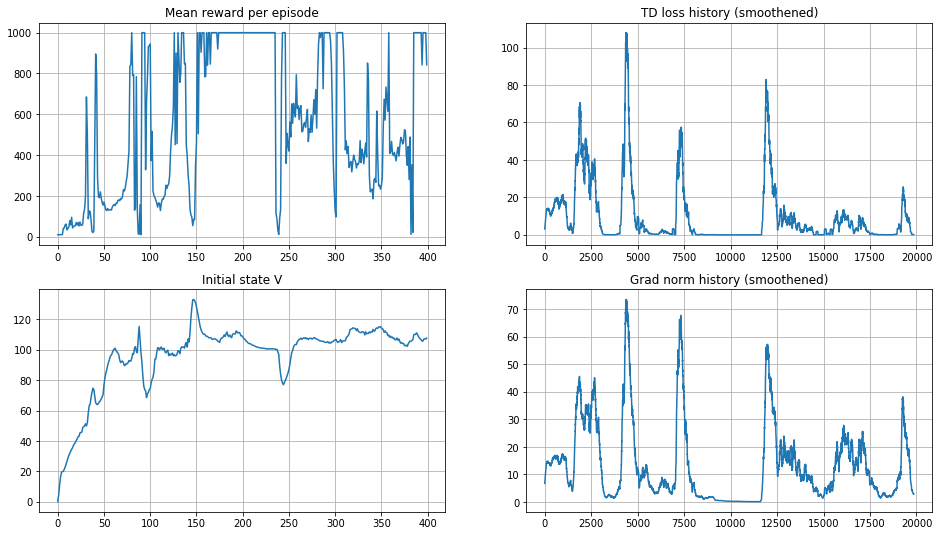

100%|██████████| 400000/400000 [17:17<00:00, 385.71it/s]


In [47]:
state = env.reset()
for step in trange(total_steps + 1):
    if not utils.is_enough_ram():
        print('less that 100 Mb RAM available, freezing')
        print('make sure everything is ok and make KeyboardInterrupt to continue')
        try:
            while True:
                pass
        except KeyboardInterrupt:
            pass

    agent.epsilon = utils.linear_decay(init_epsilon, final_epsilon, step, decay_steps)

    # play
    _, state = play_and_record(state, agent, env, exp_replay, timesteps_per_epoch)

    # train
    #< sample batch_size of data from experience replay >
    obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(batch_size)
    
    #loss = < compute TD loss >
    loss = compute_td_loss(obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch,
                       agent, target_network,
                       gamma=0.99, check_shapes=False)


    loss.backward()
    grad_norm = nn.utils.clip_grad_norm_(agent.parameters(), max_grad_norm)
    opt.step()
    opt.zero_grad()

    if step % loss_freq == 0:
        td_loss_history.append(loss.data.cpu().item())
        grad_norm_history.append(grad_norm)

    if step % refresh_target_network_freq == 0:
        # Load agent weights into target_network
        #<YOUR CODE >
        target_network.load_state_dict(agent.state_dict())

    if step % eval_freq == 0:
        # eval the agent
        mean_rw_history.append(evaluate(
            make_env(seed=step), agent, n_games=3, greedy=True, t_max=1000)
        )
        initial_state_q_values = agent.get_qvalues(
            [make_env(seed=step).reset()]
        )
        initial_state_v_history.append(np.max(initial_state_q_values))

        clear_output(True)
        print("buffer size = %i, epsilon = %.5f" %
              (len(exp_replay), agent.epsilon))

        plt.figure(figsize=[16, 9])
        plt.subplot(2, 2, 1)
        plt.title("Mean reward per episode")
        plt.plot(mean_rw_history)
        plt.grid()

        assert not np.isnan(td_loss_history[-1])
        plt.subplot(2, 2, 2)
        plt.title("TD loss history (smoothened)")
        plt.plot(utils.smoothen(td_loss_history))
        plt.grid()

        plt.subplot(2, 2, 3)
        plt.title("Initial state V")
        plt.plot(initial_state_v_history)
        plt.grid()

        plt.subplot(2, 2, 4)
        plt.title("Grad norm history (smoothened)")
        plt.plot(utils.smoothen(grad_norm_history))
        plt.grid()

        plt.show()

In [24]:
final_score = evaluate(
  make_env(),
  agent, n_games=30, greedy=True, t_max=1000
)
print('final score:', final_score)
assert final_score > 300, 'not good enough for DQN'
print('Well done')

final score: 552.2666666666667
Well done
